In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn import impute
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''Algorithms'''
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

In [2]:
# Load the data
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'lending_club_data', 'LoanStats3a.csv'])
data = pd.read_csv(current_path + file, low_memory=False)

In [9]:
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,url,dti,delinq_2yrs,inq_last_6mths,...,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,0.0,42535.000000,42506.000000,42506.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.000000,160.000000,160.000000
mean,NaN,11089.722581,10821.585753,10139.938785,322.623063,6.913656e+04,NaN,13.373043,0.152449,1.081424,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4272.137875,49.905875,1.200000
std,NaN,7410.938391,7146.914675,7131.598014,208.927216,6.409635e+04,NaN,6.726315,0.512406,1.527455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3119.373774,15.563690,4.085255
min,NaN,500.000000,500.000000,0.000000,15.670000,1.896000e+03,NaN,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.290000,10.690000,0.000000
25%,NaN,5200.000000,5000.000000,4950.000000,165.520000,4.000000e+04,NaN,8.200000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1842.750000,40.000000,0.000000
50%,NaN,9700.000000,9600.000000,8500.000000,277.690000,5.900000e+04,NaN,13.470000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3499.350000,49.970000,0.000000
75%,NaN,15000.000000,15000.000000,14000.000000,428.180000,8.250000e+04,NaN,18.680000,0.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5701.100000,60.652500,0.000000
max,NaN,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,NaN,29.990000,13.000000,33.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14798.200000,92.740000,24.000000


In [10]:
print(data.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)


In [11]:
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]

In [12]:
# View shape
data.shape

(42542, 37)

In [13]:
# Preview data
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


In [14]:
# Transform features from string to numeric
for i in ["term","int_rate","emp_length","revol_util"]:
    data.loc[:,i] = data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

In [16]:
# Determine which features are numerical
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

In [17]:
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                      7
funded_amnt                    7
funded_amnt_inv                7
term                           7
int_rate                       7
installment                    7
emp_length                  1119
annual_inc                    11
dti                            7
delinq_2yrs                   36
mths_since_last_delinq     26933
mths_since_last_record     38891
open_acc                      36
pub_rec                       36
revol_bal                      7
revol_util                    97
total_acc                     36
out_prncp                      7
out_prncp_inv                  7
total_pymnt                    7
total_pymnt_inv                7
total_rec_prncp                7
total_rec_int                  7
total_rec_late_fee             7
recoveries                     7
collection_recovery_fee        7
last_pymnt_amnt                7
dtype: int64

In [18]:
# Impute NaNs with mean 
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation
im = impute.SimpleImputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

In [19]:
data.shape

(42542, 37)

In [21]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36.0,1065.0,162.87,B,B2,10.0,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60.0,1527.0,59.83,C,C4,1.0,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36.0,1596.0,84.33,C,C5,10.0,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36.0,1349.0,339.31,C,C1,10.0,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60.0,1269.0,67.79,B,B5,1.0,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


In [23]:
# Check for NaNs one more time
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

In [24]:
# Feature engineering
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

In [25]:
# Select features for training
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

# Scale data
sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [26]:
# View columns
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

In [27]:
# Designate labels for evaluation
labels = data.grade
labels.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [31]:
# Fill missing labels for nan to Z
labels = labels.fillna(value="Z")

# Convert labels to numerical values a,b,c to 0,1,2
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name="grade")

# Store as y_train
y_train = labels

array([1, 2, 0, 4, 5, 3, 6, 7], dtype=int64)

In [32]:
# Show numerical labels
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew

,grade,grade
0,1,B
1,2,C
2,2,C
3,2,C
4,1,B
...,...,...
42537,0,A
42538,7,NaN
42539,7,NaN
42540,7,NaN


In [33]:
# Compare loan grades with interest rates
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,734.270844
1.0,1101.420857
2.0,1349.988902
3.0,1557.714927
4.0,1737.676783
5.0,1926.530361
6.0,2045.125000
7.0,1216.501563


In [34]:
# Analyze Goodness of the Clusters
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg( \
        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
        left_on="cluster",right_on="cluster")
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
        accuracyDF, overallAccuracy, accuracyByLabel

In [35]:
# Principal Component Analysis
from sklearn.decomposition import PCA

n_components = 34
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

In [36]:
# Apply K-Means on PCA Data
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state)

kMeans_inertia = pd.DataFrame(data=[],index=range(10,31), columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=range(10,31),columns=['overallAccuracy'])

for n_clusters in range(10,31):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, \
                    random_state=random_state)

    kmeans.fit(X_train_PCA)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train_PCA)
    X_train_kmeansClustered = pd.DataFrame(data= X_train_kmeansClustered, index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

<AxesSubplot:>

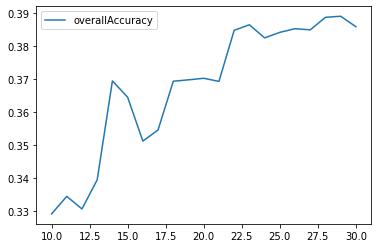

In [37]:
# View plot
overallAccuracy_kMeansDF.plot()

In [38]:
# View accuracy by cluster
accuracyByLabel_kMeans

0     0.348936
1     0.398016
2     0.364402
3     0.379694
4     0.263989
5     0.340744
6     0.786249
7     0.316598
8     0.333333
9     0.201878
10    0.232955
11    0.291765
12    0.266667
13    0.308351
14    0.380936
15    0.338082
16    0.327879
17    0.252252
18    0.362506
19    0.286008
20    0.275474
21    0.326293
22    0.308642
23    0.239521
24    0.325974
25    0.238305
26    0.351460
27    0.774488
28    0.500000
29    0.290361
dtype: float64

In [39]:
# Apply K-Means on Raw Data
from sklearn.cluster import KMeans

n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, random_state=random_state)

kMeans_inertia = pd.DataFrame(data=[],index=range(10,31), columns=['inertia'])

overallAccuracy_kMeansDF = pd.DataFrame(data=[], index=range(10,31),columns=['overallAccuracy'])

for n_clusters in range(10,31):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=max_iter, tol=tol, \
                    random_state=random_state)

    kmeans.fit(X_train)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    X_train_kmeansClustered = kmeans.predict(X_train)
    X_train_kmeansClustered = pd.DataFrame(data= X_train_kmeansClustered, index=X_train.index, columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, countMostFreq_kMeans, accuracyDF_kMeans, overallAccuracy_kMeans, accuracyByLabel_kMeans = analyzeCluster(X_train_kmeansClustered, y_train)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans

<AxesSubplot:>

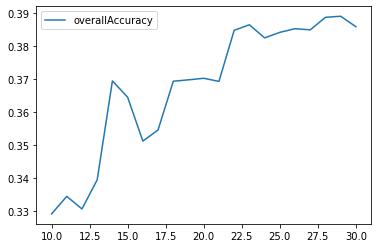

In [40]:
# View plot
overallAccuracy_kMeansDF.plot()

In [41]:
# View accuracy by cluster
accuracyByLabel_kMeans

0     0.348936
1     0.398016
2     0.364402
3     0.379694
4     0.263989
5     0.340744
6     0.786249
7     0.316598
8     0.333333
9     0.201878
10    0.232955
11    0.291765
12    0.266667
13    0.308351
14    0.380936
15    0.338082
16    0.327879
17    0.252252
18    0.362506
19    0.286008
20    0.275474
21    0.326293
22    0.308642
23    0.239521
24    0.325974
25    0.238305
26    0.351460
27    0.774488
28    0.500000
29    0.290361
dtype: float64

In [42]:
# Hierarchical Clustering Application from PCA Results
import fastcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

Z = fastcluster.linkage_vector(X_train_PCA, method='ward', \
                               metric='euclidean')

Z_dataFrame = pd.DataFrame(data=Z,columns=['clusterOne', \
                'clusterTwo','distance','newClusterSize'])

In [43]:
# View bottom most leaves
Z_dataFrame[:20]

,clusterOne,clusterTwo,distance,newClusterSize
0,39786.0,39787.0,0.000000e+00,2.0
1,39788.0,42542.0,0.000000e+00,3.0
2,42540.0,42541.0,0.000000e+00,2.0
3,42538.0,42539.0,3.035766e-18,2.0
4,42543.0,42545.0,1.101290e-16,5.0
5,42544.0,42546.0,2.823012e-16,7.0
6,33251.0,33261.0,1.561313e-01,2.0
7,42512.0,42535.0,3.342654e-01,2.0
8,42219.0,42316.0,3.368231e-01,2.0
9,6112.0,21928.0,3.384368e-01,2.0


In [44]:
# View top most leaves
Z_dataFrame[42521:]

,clusterOne,clusterTwo,distance,newClusterSize
42521,85038.0,85043.0,132.715723,3969.0
42522,85051.0,85052.0,141.386569,2899.0
42523,85026.0,85027.0,146.976703,2351.0
42524,85048.0,85049.0,152.660192,5691.0
42525,85036.0,85059.0,153.512281,5956.0
42526,85033.0,85044.0,160.825959,2203.0
42527,85055.0,85061.0,163.701428,668.0
42528,85062.0,85066.0,168.199295,6897.0
42529,85054.0,85060.0,168.924039,9414.0
42530,85028.0,85064.0,185.215769,3118.0


In [45]:
# Cluster results
from scipy.cluster.hierarchy import fcluster

distance_threshold = 100
clusters = fcluster(Z, distance_threshold, criterion='distance')
X_train_hierClustered = pd.DataFrame(data=clusters, \
    index=X_train.index,columns=['cluster'])

In [46]:
# Show number of clusters created
print("Number of distinct clusters: ", \
      len(X_train_hierClustered['cluster'].unique()))

Number of distinct clusters:  32


In [47]:
# Show overall accuracy
countByCluster_hierClust, countByLabel_hierClust, \
    countMostFreq_hierClust, accuracyDF_hierClust, \
    overallAccuracy_hierClust, accuracyByLabel_hierClust = \
    analyzeCluster(X_train_hierClustered, y_train)

print("Overall accuracy from hierarchical clustering: ", \
      overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.3651685393258427


In [48]:
# Show accuracy by cluster
print("Accuracy by cluster for hierarchical clustering")
accuracyByLabel_hierClust

Accuracy by cluster for hierarchical clustering


0     0.304124
1     0.219001
2     0.228311
3     0.379722
4     0.240064
5     0.272011
6     0.314560
7     0.263930
8     0.246138
9     0.318942
10    0.302752
11    0.269772
12    0.335717
13    0.330403
14    0.346320
15    0.440141
16    0.744155
17    0.502227
18    0.294118
19    0.236111
20    0.254727
21    0.241042
22    0.317979
23    0.308771
24    0.284314
25    0.243243
26    0.500000
27    0.289157
28    0.365283
29    0.479693
30    0.393559
31    0.340875
dtype: float64

In [49]:
# HDBSCAN Application
import hdbscan

min_cluster_size = 20
min_samples = 20
alpha = 1.0
cluster_selection_method = 'leaf'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, \
    min_samples=min_samples, alpha=alpha, \
    cluster_selection_method=cluster_selection_method)

X_train_hdbscanClustered = hdb.fit_predict(X_train_PCA)
X_train_hdbscanClustered = pd.DataFrame(data= \
    X_train_hdbscanClustered, index=X_train.index, \
    columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
    countMostFreq_hdbscan, accuracyDF_hdbscan, \
    overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
    analyzeCluster(X_train_hdbscanClustered, y_train)

In [50]:
# Show overall accuracy
print("Overall accuracy from HDBSCAN: ", overallAccuracy_hdbscan)

Overall accuracy from HDBSCAN:  0.3258426966292135


In [51]:
# Count by cluster
print("Cluster results for HDBSCAN")
countByCluster_hdbscan

Cluster results for HDBSCAN


,cluster,clusterCount
0,-1,32478
1,6,4261
2,2,3668
3,1,1096
4,4,786
5,0,120
6,7,72
7,3,38
8,5,23


In [52]:
# Accuracy by cluster
accuracyByLabel_hdbscan

0    0.284346
1    0.341667
2    0.414234
3    0.332061
4    0.552632
5    0.438931
6    0.391304
7    0.588829
8    0.416667
dtype: float64